<a href="https://colab.research.google.com/github/tomaszpionka/ds-project/blob/main/wum4zaoczne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sieci konwolucyjne (CNN)

In [ ]:
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn

# transform - tworzymy przekształcenie obrazu na pytorchowy tensor, oraz normalizujemy
import torch
from torchvision import transforms, datasets

data_transform = transforms.Compose([
        # transforms.RandomResizedCrop(28),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,),(0.3081,))
    ])

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]) #normalizowanie - średnia i wariancja. liczby podane od pytorch


#ładowanie danch, za pierwszym razem dane zostaną pobrane
train_set = torchvision.datasets.MNIST('./data/mnist', train=True, download=True, 
                  transform=data_transform)
test_set = torchvision.datasets.MNIST('./data/mnist', train=False, download=True, 
                  transform=transform)

train_set=torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)
test_set=torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=True)

len(train_set)


Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw




Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


600

In [ ]:
for t in train_set:
  print(t[0].shape)
  break

torch.Size([100, 1, 28, 28])


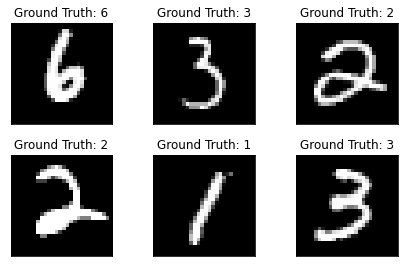

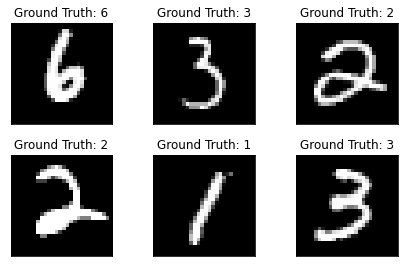

In [ ]:
import matplotlib.pyplot as plt

train = enumerate(train_set)

index, (example_data, example_targets)= next(train)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1=nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=2) #inchannels =1 dlatego, że obraz jest czarnobialy
        # self.norm=nn.BatchNorm2d(32)

        self.relu=nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)#kernel_size,stride

        self.conv2=nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.relu2=nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)


    def forward(self, x):
        # print(x.shape) #--> [100, 1, 28, 28]
        out = self.conv1(x)
        # print(out.shape) #--> [100, 32, 28, 28]
        # out=self.norm(out)
        out=self.relu(out)
        # print(out.shape) #--> [100, 32, 28, 28]
        out=self.pool(out)
        # print(out.shape) #--> [100, 32, 14, 14]
        # print("conv2")
        out = self.conv2(out)
        # print(out.shape) #--> [100, 64, 14, 14]
        out=self.relu2(out)
        # print(out.shape) #--> [100, 64, 14, 14]
        out=self.pool2(out)
        #print(out.shape)
        out = out.reshape(out.size(0), -1)# przed przekazaniem dalej do wartswty liniowej, sprowadzamy do jednego wymiaru
        #print(out.shape)
        
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

Rozmiar wyjściowy każdej warstwy (conv oraz pooling), może być obliczony za pomocą wzoru:

$W_{out}= \frac{W_{in}-F+2P}{stride} + 1$

W_in-rozmiar wejściowy brazu (nie mylić z input_channels)

F-rozmiar filtru (kernel size)

P-rozmiar "padding"- dodatkowych "pustych" pikseli

stride - liczba pikseli, co ile jest przesuwany filtr

In [ ]:
model = ConvNet().cuda()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.1)

In [ ]:
# Train the model
total_step = len(train_set)
loss_list = []
acc_list = []
num_epochs=5
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_set):
        # Run the forward pass
        labels=labels.cuda()
        outputs = model(images.cuda())
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/5], Step [100/600], Loss: 0.5488, Accuracy: 83.00%
Epoch [1/5], Step [200/600], Loss: 0.5087, Accuracy: 82.00%
Epoch [1/5], Step [300/600], Loss: 0.4235, Accuracy: 88.00%
Epoch [1/5], Step [400/600], Loss: 0.3351, Accuracy: 91.00%
Epoch [1/5], Step [500/600], Loss: 0.3256, Accuracy: 93.00%
Epoch [1/5], Step [600/600], Loss: 0.2411, Accuracy: 98.00%
Epoch [2/5], Step [100/600], Loss: 0.3004, Accuracy: 93.00%
Epoch [2/5], Step [200/600], Loss: 0.2083, Accuracy: 97.00%
Epoch [2/5], Step [300/600], Loss: 0.2915, Accuracy: 95.00%
Epoch [2/5], Step [400/600], Loss: 0.2696, Accuracy: 90.00%
Epoch [2/5], Step [500/600], Loss: 0.3413, Accuracy: 92.00%
Epoch [2/5], Step [600/600], Loss: 0.3643, Accuracy: 91.00%
Epoch [3/5], Step [100/600], Loss: 0.2975, Accuracy: 91.00%
Epoch [3/5], Step [200/600], Loss: 0.3369, Accuracy: 88.00%
Epoch [3/5], Step [300/600], Loss: 0.2126, Accuracy: 96.00%
Epoch [3/5], Step [400/600], Loss: 0.2493, Accuracy: 94.00%
Epoch [3/5], Step [500/600], Loss: 0.273

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_set:
        labels=labels.cuda()
        outputs = model(images.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the test images: {} %'.format((correct / total) * 100))

Test Accuracy of the model on the test images: 94.76 %



## Facial keypoints detection
Utwórz sieć konwolucyjną, która identyfikuje punkty na twarzy.

Dane znajdują się w folderze facialkeypoints. Pierwsze 30 kolumn zawiera współrzędne punktów na twarzy. 31 kolumna zawiera czarnobiałą reprezentację obrazu. Wyświetl w pythonie, kilka przykładowych obrazów(plt.imshow),wraz z punktami(plt.scatter). Rozmiar obrazu to 96 x 96

Przygotuj własną klasę dziedziczącą po Dataset, która pozwoli na wczytanie zbioru danych w odpowiedniej formie. (torch.utils.data.Dataset) Wyczyść dane: usuń te sample gdzie występują wartości puste, sprawdz czy każdy obraz ma podobny rozmiar.

Podziel dane treningowe i testowe i wczytaj je za pomocą dataset
Wykorzystaj DataLoader do iteracji po danych testowych i treningowych. (torch.utils.data.DataLoader)

Zaprojektuj architekturę sieci konwolucyjnej do zadania regresji. Użyj minimum dwóch warstw konwolucyjnych z i conajmniej jednej warstwy liniowej. Użyj odpowiedniej funkcji kosztu- pamietajac ze nie jest to klasyfikacja .

https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#

Do tego zadania możesz usunąć przykłady z brakującymi danymi.